# RNN (2)
---
(혼공 526p~)
## 고급 순환층 LSTM, GRU
앞의 SimpleRNN 층보다 더 복잡하지만 성능이 뛰어난 LSTM, GRU 층에 대해 알아보자.
1. LSTM
2. GRU

## 1️⃣ LSTM (Long-Short-Term-Memory)
단기 기억을 오래 기억하기 위해 고안되었다.  
마치 작은 셀 여러 개를 포함한 구조이다. LSTM은 4개의 셀로 구성된다.

### 셀 상태
> 각 셀은 입력과 은닉 상태에 각기 다른 가중치를 곱한 후 sigmoid 함수를 통과시킨다.  
> -  출력게이트, 삭제 게이트  
>       이전 셀 상태와 곱해진 후 tanh를 통과한 값이 은닉상태와 곱해져 새로운 은닉상태를 만든다.
> -  입력게이트  
>       tanh 함수를 통과 한 값과 sigmoid 함수를 통과한 값을 곱한 후 이전 셀 상태와 더하면 최종적인 셀 상태가 된다.

각설하고, keras의 LSTM 클래스를 사용하면 위의 layer를 구현할 수 있다. 

### Data load

In [5]:
from tensorflow.keras.datasets import imdb

(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=500)

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

제 각각인 리뷰 길이를 100으로 맞춘다. 여기에는 keras에서 제공하는 pad_sequence 함수를 사용한다.

In [8]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

train_seq = pad_sequences(X_train, maxlen=100)
val_seq = pad_sequences(X_val, maxlen=100)

## 1) LSTM
### Construct model

In [10]:
from tensorflow import keras

model = keras.Sequential()

model.add(keras.layers.Embedding(500, 16))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(1, activation='sigmoid')) # output layer

### Train model

In [12]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-lstm-model.keras', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

history = model.fit(train_seq, y_train, epochs=100, batch_size=64,
         validation_data=(val_seq, y_val), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.5050 - loss: 0.6931 - val_accuracy: 0.5338 - val_loss: 0.6925
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 53ms/step - accuracy: 0.5560 - loss: 0.6921 - val_accuracy: 0.5584 - val_loss: 0.6914
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 51ms/step - accuracy: 0.5829 - loss: 0.6905 - val_accuracy: 0.5916 - val_loss: 0.6891
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 54ms/step - accuracy: 0.6163 - loss: 0.6875 - val_accuracy: 0.6470 - val_loss: 0.6823
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 52ms/step - accuracy: 0.6797 - loss: 0.6731 - val_accuracy: 0.6740 - val_loss: 0.6425
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 56ms/step - accuracy: 0.6827 - loss: 0.6349 - val_accuracy: 0.6862 - val_loss: 0.6229
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 56ms/step - accuracy: 0.7024 - loss: 0.6135 - val_accuracy: 0.7196 - val_loss: 0.5985
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 54ms/step - accuracy: 0.7295 - loss: 0

In [13]:
early_stopping_cb.best_epoch

41

In [14]:
model.evaluate(val_seq, y_val)

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8007 - loss: 0.4282


[0.4266113340854645, 0.8029999732971191]

앞의 simpleRNN으로 구현했을 때는 accuracy가 70점대였던 거와 비교하면 성능이 많이 좋아졌다는 것을 알 수 있다.

### Plot

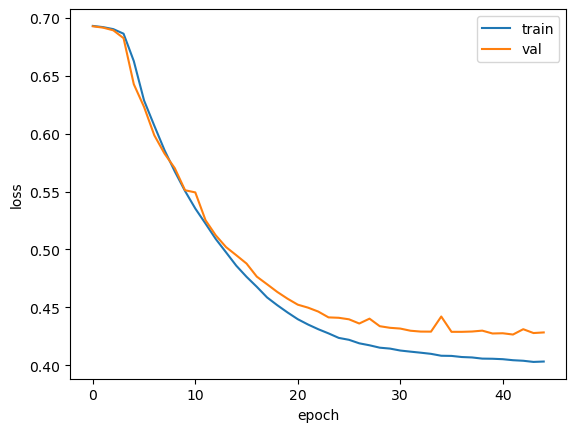

In [17]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

## 2) LSTM - Dropout 
### Model Construct

과대적합을 막기 위한 dropout layer를 추가하여 model을 구성해보자.

   >#### Dropout layer
   >훈련할 데이터를 랜덤하게 추출하여 학습함으로써 과대적합을 막는다.


순환층은 자체적으로 dropout, recurrent_dropout 매개변수를 통해 dropout 기능을 제공한다.
- dropout : 셀 입력에 적용
- recurrent_dropout : 순환하는 은닉상태에 적용

In [35]:
model2 = keras.Sequential()

model2.add(keras.layers.Embedding(500, 16))
model2.add(keras.layers.LSTM(8, dropout=0.3)) # 입력의 30%를 drop한다.
model2.add(keras.layers.Dense(1, activation='sigmoid'))

### Train Model 

In [44]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model2.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-dropout-model.keras', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

history = model2.fit(train_seq, y_train, epochs=100, batch_size=64,
         validation_data=(val_seq, y_val), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 62ms/step - accuracy: 0.4982 - loss: 0.6931 - val_accuracy: 0.5706 - val_loss: 0.6918
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 62ms/step - accuracy: 0.5700 - loss: 0.6912 - val_accuracy: 0.6106 - val_loss: 0.6894
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 59ms/step - accuracy: 0.6048 - loss: 0.6882 - val_accuracy: 0.6272 - val_loss: 0.6844
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 59ms/step - accuracy: 0.6262 - loss: 0.6824 - val_accuracy: 0.6496 - val_loss: 0.6735
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 58ms/step - accuracy: 0.6534 - loss: 0.6673 - val_accuracy: 0.7042 - val_loss: 0.6355
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 59ms/step - accuracy: 0.7017 - loss: 0.6209 - val_accuracy: 0.7242 - val_loss: 0.5825
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 60ms/step - accuracy: 0.7316 - loss: 0.5771 - val_accuracy: 0.7366 - val_loss: 0.5601
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 60ms/step - accuracy: 0.7477 - loss: 0

### Plot

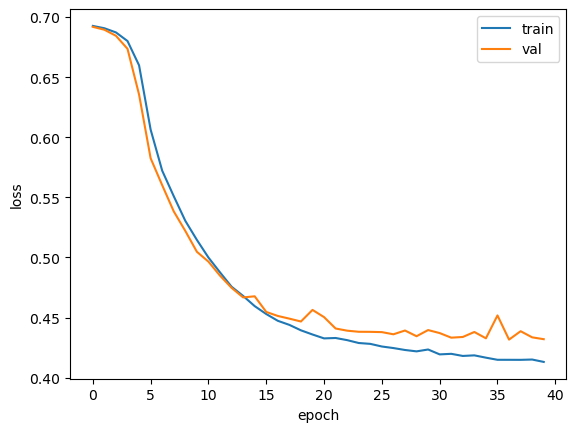

In [52]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

### Evaluate

In [54]:
model2.evaluate(val_seq, y_val)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7960 - loss: 0.4330


[0.43164029717445374, 0.7975999712944031]

## 3) Multi-LSTM - dropout
- LSTM  
순환층은 마지막 타임스텝에 대한 은닉 상태만 출력한다.  
모든 순환층은 input으로 순차적 data를 기대한다.  
따라서 순환층을 여러겹 쌓을 경우, 앞의 순환층에선 모든 타임스텝의 은닉상태를 출력하고, 마지막 순환층에서만 마지막 타임스텝에 대한 은닉상태를 출력해야 한다.  
👉 이는 마지막 층을 제외한 모든 순환층에서 return_sequences=True를 설정하면 된다.

### Construct Model

In [58]:
model3 = keras.Sequential()

model3.add(keras.layers.Embedding(500, 16))
model3.add(keras.layers.LSTM(8, dropout=0.3, return_sequences=True))
model3.add(keras.layers.LSTM(8, dropout=0.3))
model3.add(keras.layers.Dense(1, activation='sigmoid')) # output layer

### Train model

In [60]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model3.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-2rnn-model.keras', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

history = model3.fit(train_seq, y_train, epochs=100, batch_size=64,
                    validation_data=(val_seq, y_val), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 98ms/step - accuracy: 0.5130 - loss: 0.6930 - val_accuracy: 0.5882 - val_loss: 0.6922
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 32s 104ms/step - accuracy: 0.5603 - loss: 0.6918 - val_accuracy: 0.6332 - val_loss: 0.6896
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 117ms/step - accuracy: 0.6100 - loss: 0.6879 - val_accuracy: 0.6634 - val_loss: 0.6796
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 117ms/step - accuracy: 0.6447 - loss: 0.6731 - val_accuracy: 0.6900 - val_loss: 0.6426
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 33s 106ms/step - accuracy: 0.6824 - loss: 0.6303 - val_accuracy: 0.7198 - val_loss: 0.5797
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 34s 110ms/step - accuracy: 0.7216 - loss: 0.5740 - val_accuracy: 0.7406 - val_loss: 0.5418
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 43s 136ms/step - accuracy: 0.7418 - loss: 0.5436 - val_accuracy: 0.7492 - val_loss: 0.5220
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 40s 128ms/step - accuracy: 0.7521 - 

In [62]:
early_stopping_cb.best_epoch

17

### Plot

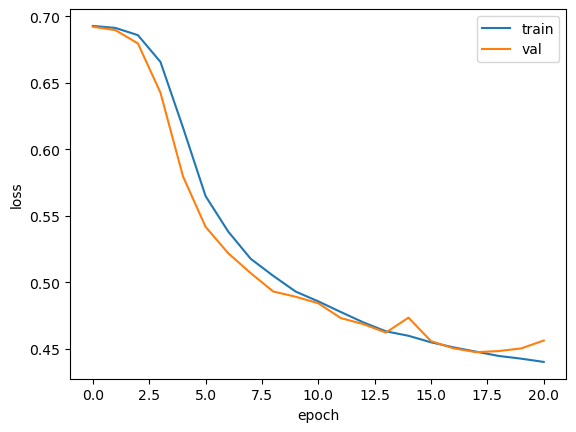

In [64]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

## Evaluate

In [67]:
model3.evaluate(val_seq, y_val)

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7915 - loss: 0.4508


[0.44751787185668945, 0.79339998960495]

## 2️⃣ GRU (Gated Recurrent Unit)
LSTM의 간소화된 버전으로, 3개의 셀로 구성된다.  
활성화 함수로 두 개의 셀은 sigmoid를 나머지 하나는 tanh를 쓴다.  
세 값이 어떻게 활용되는 지 알아보자.  
> - sigmoid를 통과한 값 하나는 은닉층에 곱해져 삭제 게이트 역할을 하는 동시에,
>   같은 값이 1에서 뺀 후 tanh를 통과 한 값과 곱해져, 입력 정보를 제어한다.
> - sigmoid를 통과한 나머지 값 하나는 이전 은닉층과 곱해져 tanh 함수를 사용하는 셀의 입력으로 들어가, 은닉층을 제어한다.


## 4) GRU

### Model Construct

In [74]:
model4 = keras.Sequential()

model4.add(keras.layers.Embedding(500, 16))
model4.add(keras.layers.GRU(8))
model4.add(keras.layers.Dense(1, activation='sigmoid'))

In [80]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model4.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-gru-model.keras', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

history = model4.fit(train_seq, y_train, epochs=100, batch_size=64,
                    validation_data=(val_seq, y_val), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 59ms/step - accuracy: 0.4964 - loss: 0.6933 - val_accuracy: 0.5164 - val_loss: 0.6930
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 61ms/step - accuracy: 0.5266 - loss: 0.6927 - val_accuracy: 0.5520 - val_loss: 0.6922
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 63ms/step - accuracy: 0.5708 - loss: 0.6917 - val_accuracy: 0.5674 - val_loss: 0.6910
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 64ms/step - accuracy: 0.5833 - loss: 0.6904 - val_accuracy: 0.5782 - val_loss: 0.6892
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 66ms/step - accuracy: 0.5931 - loss: 0.6882 - val_accuracy: 0.5850 - val_loss: 0.6864
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 65ms/step - accuracy: 0.6005 - loss: 0.6849 - val_accuracy: 0.5888 - val_loss: 0.6820
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - accuracy: 0.6093 - loss: 0.6791 - val_accuracy: 0.5988 - val_loss: 0.6754
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - accuracy: 0.6229 - loss: 0

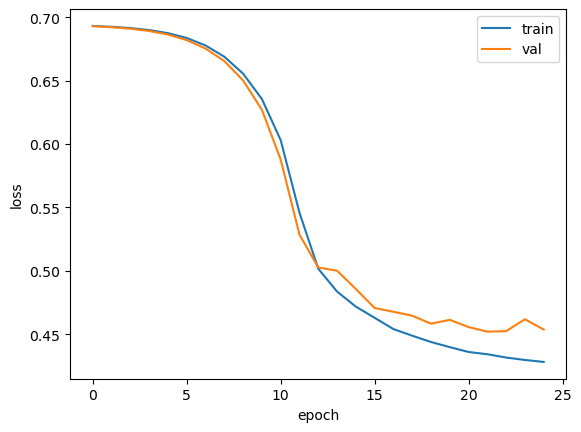

In [82]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [84]:
model4.evaluate(val_seq, y_val)

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7886 - loss: 0.4556


[0.4519541561603546, 0.7906000018119812]